In [1]:
# TODO:  
%config Completer.use_jedi = False

In [2]:
%pylab inline
import gala.potential as gp
from gala.units import galactic, solarsystem, dimensionless
#import coefficients_smoothing
from bfe import coefficients
sys.path.append('../code/')
#from mwlmc_bfe import smooth_coeff
import coefficients_smoothing 
import bfe.ios as ios


Populating the interactive namespace from numpy and matplotlib


In [3]:
font = {'size':20, 'family':'serif'}
matplotlib.rc('font', **font)

In [4]:
coeff_lmc_path = '../data/interim/BFE/MW_test/BFE_MWLMC5_b1_center_fix_sat_bound_snap'
coeff_mw_path =  '../data/interim/BFE/MW_test/BFE_MWLMC5_b1_center_fix_host_snap'
coeff_mwlmc_path = '../data/interim/BFE/MW_test/BFE_MWLMC5_b1_center_fix_host_sat_unbound_snap'

mass_host = 1.291e-05
mass_sat = 3.226e-05
#mass = 1.577212515257997438e-06

In [5]:
S_lmc, T_lmc, SS_lmc, TT_lmc, ST_lmc = coefficients_smoothing.read_coeffcov_matrix(coeff_lmc_path, 0, 20, 20, 20, snaps=110, read_type=0)
S_mw, T_mw, SS_mw, TT_mw, ST_mw = coefficients_smoothing.read_coeffcov_matrix(coeff_mw_path, 0, 20, 20, 20, snaps=110, read_type=0)
S_mwlmc, T_mwlmc, SS_mwlmc, TT_mwlmc, ST_mwlmc = coefficients_smoothing.read_coeffcov_matrix(coeff_mwlmc_path, 0, 20, 20, 20, snaps=110, read_type=0)

In [6]:
S_lmc_smooth, T_lmc_smooth, N = coefficients_smoothing.smooth_coeff_matrix(S_lmc, T_lmc, 
                                                                           SS_lmc, TT_lmc, ST_lmc, 
                                                                           mass_sat, 20, 20, 20, 10, 0)


S_mw_smooth, T_mw_smooth, N = coefficients_smoothing.smooth_coeff_matrix(S_mw, T_mw, 
                                                                           SS_mw, TT_mw, ST_mw, 
                                                                           mass_host, 20, 20, 20, 6, 0)

S_mwlmc_smooth, T_mwlmc_smooth, N = coefficients_smoothing.smooth_coeff_matrix(S_mwlmc, T_mwlmc, 
                                                                           SS_mwlmc, TT_mwlmc, ST_mwlmc, 
                                                                           mass_host, 20, 20, 20, 5, 0)

../code/coefficients_smoothing.py:128: RuntimeWarning: invalid value encountered in double_scalars
  bt = 1 / (1 + (varT/T**2))


<ipython-input-7-b0fd75adbdce>:1: RuntimeWarning: divide by zero encountered in log10
  imshow(np.log10(np.abs(S_lmc_smooth[:,:,0].T)), origin='lower')


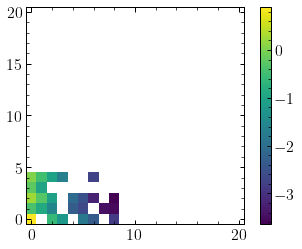

In [7]:
imshow(np.log10(np.abs(S_lmc_smooth[:,:,0].T)), origin='lower')
colorbar()

<ipython-input-8-0c2b81c5c9b2>:1: RuntimeWarning: divide by zero encountered in log10
  imshow(np.log10(np.abs(S_mw_smooth[:,:,0].T)), origin='lower')


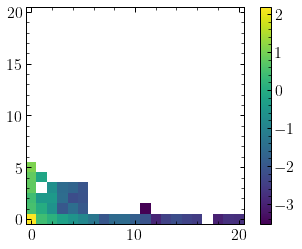

In [8]:
imshow(np.log10(np.abs(S_mw_smooth[:,:,0].T)), origin='lower')
colorbar()

In [9]:
S_mw_wake = np.copy(S_mw_smooth)
T_mw_wake = np.copy(T_mw_smooth)
#S_mw_wake[0,0,0] = 0
#T_mw_wake[0,0,0] = 0

S_mw_ref = np.zeros(shape(S_mw_smooth))
T_mw_ref = np.zeros(shape(T_mw_smooth))
S_mw_ref[0,0,0] = S_mw[0,0,0]
T_mw_ref[0,0,0] = T_mw[0,0,0]


S_mwlmc_ref = np.zeros(shape(S_mwlmc))
T_mwlmc_ref = np.zeros(shape(T_mwlmc))
S_mwlmc_ref[0,0,0] = S_mwlmc[0,0,0]
T_mwlmc_ref[0,0,0] = T_mwlmc[0,0,0]
## almc + awake

In [10]:
#index_mw = np.where(S_mw > 0)
#index_mwlmc = np.where(S_mwlmc > 0)
#index_lmc = np.where(S_lmc > 0)


In [11]:

def spherical_grid_shift(xyz, shift_com):
    x_shift = xyz[:,0] - shift_com[0]
    y_shift = xyz[:,1] - shift_com[1]
    z_shift = xyz[:,2] - shift_com[2]
    return np.ascontiguousarray(np.array([x_shift, y_shift, z_shift]).T)

def grid(box_size, nbins):
    y_grid = np.linspace(-box_size/2., box_size/2., nbins)
    z_grid = np.linspace(-box_size/2., box_size/2., nbins)
    nbins = len(y_grid)
    y_grid, z_grid = np.meshgrid(y_grid, z_grid)
    
    return y_grid, z_grid, nbins

def bfe_a_grid(S1, T1, y_grid, z_grid, rs):
    xyz = np.ascontiguousarray(np.array([np.zeros(len(y_grid.flatten())),
                                             y_grid.flatten(),
                                             z_grid.flatten()]).T)
    
    a = biff.gradient(xyz, S1, T1, M=1, r_s=rs, G=1)
    a_mw = (a[:,0]**2 + a[:,1]**2 + a[:,2]**2)**0.5
    return a_mw

def bfe_rho_grid(S1, T1, y_grid, z_grid, rs, shift=0):
    xyz = np.ascontiguousarray(np.array([np.zeros(len(y_grid.flatten())),
                                             y_grid.flatten(),
                                             z_grid.flatten()]).T)
    
    if shift==1:
        xyz = spherical_grid_shift(xyz, [-1.6172733999999993, -41.39907439, -27.93125875])
    
    rho_biff = gp.SCFPotential(m=1, Snlm=S1, Tnlm=T1, r_s=rs)
    rho = rho_biff.density(xyz.T)
    return rho

In [12]:
ygr, zgr, _ = grid(400, 100)
#a_wake = bfe_a_grid(S_mw_wake, T_mw_wake, ygr, zgr, 40.85)
#rho_wake = bfe_rho_grid(S_mw_wake, T_mw_wake, ygr, zgr, 40.85)
#rho_wake2 = bfe_rho_grid(S_mw/S_mw_ref, T_mw/T_mw_ref, ygr, zgr, 40.85)

In [13]:
#a_mw = bfe_a_grid(S_mw, T_mw, ygr, zgr, 40.85)
#a_mw_ref = bfe_a_grid(S_mw_ref, T_mw_ref, ygr, zgr, 40.85)

rho_mw = bfe_rho_grid(S_mw, T_mw, ygr, zgr, 40.85)
rho_mw_ref = bfe_rho_grid(S_mw_ref, T_mw_ref, ygr, zgr, 40.85)

In [14]:
rho_mwf = bfe_rho_grid(S_mwlmc, T_mwlmc, ygr, zgr, 40.85)
rho_mwlmc_ref = bfe_rho_grid(S_mwlmc_ref, T_mwlmc_ref, ygr, zgr, 40.85)
rho_lmc = bfe_rho_grid(S_lmc, T_lmc, ygr, zgr, 10, shift=1)


In [15]:
LMC = ios.read_snap_coordinates('../../MW_anisotropy/code/test_snaps/', 'MWLMC5_100M_new_b1_110', 100000000, galaxy='sat')

Loading snapshot: ../../MW_anisotropy/code/test_snaps/MWLMC5_100M_new_b1_110
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Potential
Returning DM    Mass
Loading MW particles and LMC particles
Loading satellite particles
Computing coordinates in the MW COM frame
Returning DISK  Positions
Returning DISK  Velocities
Returning DISK  Potential
[ 9.19391488 42.1269949  -3.31300547] [ 10.34109411  28.95649597 -39.88921287]


In [19]:
# LMC orbit
orbit = np.loadtxt('../../MW_anisotropy/data/orbits/LMC5_100Mb0_orbit.txt')

In [20]:
lmc_wrt_mw = orbit[:110,6:9] - orbit[:110,0:3]

In [16]:
rp = np.random.randint(0, len(LMC[0]), 4000)

<ipython-input-28-50e0ac06da0b>:110: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


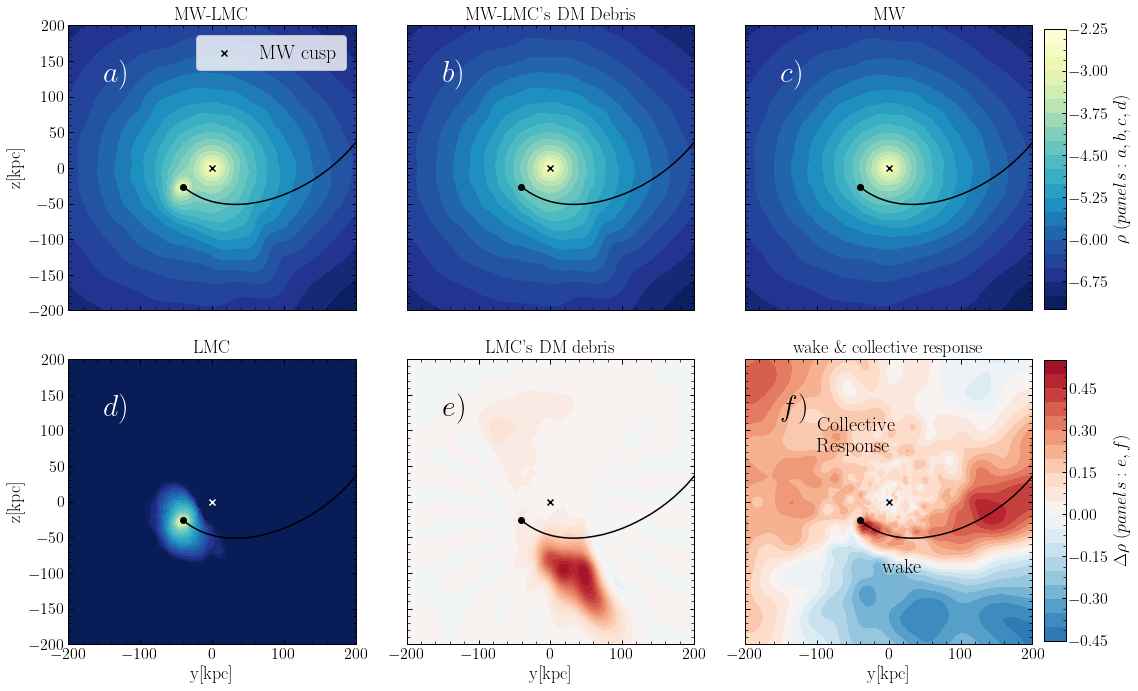

In [28]:

fig, ax = plt.subplots(2, 3, figsize=(15,10), sharex=True, sharey=True)

#title('MW with LMC')
im1 = ax[0][0].contourf(ygr, zgr, np.log10(np.abs((rho_lmc+rho_mwf).reshape(_, _))), 20
         , cmap='YlGnBu_r', vmin=-7.2, vmax=-2.3)
#scatter(-41, -28, c='k')
ax[0][0].scatter(lmc_wrt_mw[109,1], lmc_wrt_mw[109,2], c='k')

ax[0][0].set_ylabel('z[kpc]')
ax[1][0].set_ylabel('z[kpc]')

ax[1][0].set_xlabel('y[kpc]')
ax[1][1].set_xlabel('y[kpc]')
ax[1][2].set_xlabel('y[kpc]')

ax[0][0].plot(lmc_wrt_mw[:,1], lmc_wrt_mw[:,2], c='k')
ax[0][1].plot(lmc_wrt_mw[:,1], lmc_wrt_mw[:,2], c='k')
ax[0][2].plot(lmc_wrt_mw[:,1], lmc_wrt_mw[:,2], c='k')
ax[1][0].plot(lmc_wrt_mw[:,1], lmc_wrt_mw[:,2], c='k')
ax[1][1].plot(lmc_wrt_mw[:,1], lmc_wrt_mw[:,2], c='k')
ax[1][2].plot(lmc_wrt_mw[:,1], lmc_wrt_mw[:,2], c='k')


#subplot(2, 3, 2)
#title('MW with LMC debris')

ax[0][1].contourf(ygr, zgr, np.log10(np.abs((rho_mwf).reshape(_, _))), 20, cmap='YlGnBu_r', vmin=-7.2, vmax=-2.3)
#xlabel('y[kpc]')
ax[0][1].scatter(lmc_wrt_mw[109,1], lmc_wrt_mw[109,2], c='k')

#subplot(2, 3, 3)
#title('MW with LMC debris')

ax[0][2].contourf(ygr, zgr, np.log10(np.abs((rho_mw).reshape(_, _))), 20, cmap='YlGnBu_r', vmin=-7.2, vmax=-2.3)
#xlabel('y[kpc]')
ax[0][2].scatter(lmc_wrt_mw[109,1], lmc_wrt_mw[109,2], c='k')


#subplot(2, 3, 4)
#title('LMC')
im2 = ax[1][0].contourf(ygr, zgr, np.log10(np.abs((rho_lmc).reshape(_, _))), np.linspace(-6.2, -2.3, 20), 
                        cmap='YlGnBu_r', extend='both')
#xlabel('y[kpc]')
ax[1][0].scatter(lmc_wrt_mw[109,1], lmc_wrt_mw[109,2], c='k')


#subplot(2, 3, 5)
#title('LMC debris')
ax[1][1].contourf(ygr, zgr, (((rho_mwf/rho_mw).reshape(_, _)))-1, 20, cmap='RdBu_r', vmin=-1.5, vmax=1.5)
#colorbar()
ax[1][1].scatter(lmc_wrt_mw[109,1], lmc_wrt_mw[109,2], c='k')
#ylabel('z[kpc]')
#xlabel('y[kpc]')

#subplot(2, 3, 6)
#title('Wake')
im3 = ax[1][2].contourf(ygr, zgr, (((rho_mw/rho_mw_ref).reshape(_, _)))-1, 20, cmap='RdBu_r', vmin=-0.6, vmax=0.62)
#colorbar()
ax[1][2].scatter(lmc_wrt_mw[109,1], lmc_wrt_mw[109,2], c='k')
#xlabel('y[kpc]')

ax[0][0].text(-150, 120, '$a)$', color='w', fontsize=30)
ax[0][1].text(-150, 120, '$b)$', color='w', fontsize=30)
ax[0][2].text(-150, 120, '$c)$', color='w', fontsize=30)
ax[1][0].text(-150, 120, '$d)$', color='w', fontsize=30)
ax[1][1].text(-150, 120, '$e)$', color='k', fontsize=30)
ax[1][2].text(-150, 120, '$f)$', color='k', fontsize=30)


#ax[1][1].scatter(LMC[0][rp, 1], LMC[0][rp, 2], c='C0', s=1)
ax[1][1].set_xlim(-200, 200)
ax[1][1].set_ylim(-200, 200)

cax1 = fig.add_axes([0.98, 0.55, 0.02, 0.39]) 
cb1 = fig.colorbar(im1, cax=cax1)
cb1.set_label(r'$\rho\ (panels: a, b, c, d)$')

#cax2 = fig.add_axes([0.325, 0.09, 0.02, 0.41]) 
#cb2 = fig.colorbar(im2, cax=cax2)
#cb2.ax.tick_params(labelsize=15)
#cb2.set_label(r'$\rho$')


cax3 = fig.add_axes([0.98, 0.09, 0.02, 0.39]) 
cb3 = fig.colorbar(im3, cax=cax3)
cb3.set_label(r'$\Delta \rho\ (panels: e, f)$')

ax[0][0].scatter(0, 0, c='k', marker='x', label='MW cusp')
ax[0][1].scatter(0, 0, c='k', marker='x')
ax[0][2].scatter(0, 0, c='k', marker='x')
ax[1][0].scatter(0, 0, c='w', marker='x')
ax[1][1].scatter(0, 0, c='k', marker='x')
ax[1][2].scatter(0, 0, c='k', marker='x')

ax[0][0].legend()

ax[0][0].set_title('MW-LMC')
ax[0][1].set_title("MW-LMC's DM Debris")
ax[0][2].set_title('MW')
ax[1][0].set_title('LMC')
ax[1][1].set_title("LMC's DM debris")
ax[1][2].set_title('wake \& collective response')


ax[1][2].text(-10, -100, 'wake', color='k', fontsize=20)
ax[1][2].text(-100, 100, 'Collective', color='k', fontsize=20)
ax[1][2].text(-100, 70, 'Response', color='k', fontsize=20)


fig.tight_layout()

savefig('fig1.pdf', bbox_inches='tight')
#savefig('mw_lmc4_dens_bfe_v2.png', bbox_inches='tight')
#savefig('mw_lmc4_dens_bfe_v2.pdf', bbox_inches='tight')

## Make sure the plots are square, and fix the colorbar size


In [80]:
ids_lmc = np.loadtxt('../data/interim/BFE/MW_test/MWLMC5_100M_new_b1_bound_sat_ids_110')

In [81]:
len(ids_lmc)

190556